In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

# Specify data folder
data_folder = '/app/data'

# Load the dataset
data_sv_dict = util.split_by_field(util.load_cmapss_data(data_folder), field='src')
data = data_sv_dict['train_FD004']
# Define input folders
dt_in = list(data.columns[3:-1])
# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = data.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]
# Split datasets
tr, ts = util.partition_by_machine(data, tr_mcn)
# Rescale
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)

# Last step for prediction plots
stop = 1400
# Define the cost model
tr_failtimes = tr.groupby('machine')['cycle'].max()
safe_interval = tr_failtimes.min()
maintenance_cost = tr_failtimes.max()
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Classifier-Based RUL Policies

Boring start, interesting consequences

## RUL Prediction as Classification

**Since we have established that RUL prediction is hard**

...Why don't we got for a classification approach?

* Classification is often easier than regression
* ...And it would remove our "fake" high RUL values when the machine is healthy
* ...Since those point will all belong to the same "healthy" class

**Formally, let's predict when the end of life is approaching, i.e.:**

$$
f(x, \omega) = \left\{\begin{aligned}
0 & \text{ if RUL} < \theta \\
1 & \text{ otherwise}
\end{aligned}\right.$$

* $f$ is the classifier (with parameter vector $\omega$)
* $\theta$ is defines what we mean by "approaching"

**The idea is to stop as soon as the classifier outputs a 1**

## Fool Me Once...

**Let's not make the same mistake twice**

...And start by drafting a _problem formulation_:

$$
\text{argmin}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \omega^*), 0.5) \\
\text{ with: } \omega^* = \text{argmin}_\omega \{ L(y, \mathbb{1}_{\hat{y} \geq \theta}) \mid y = f(x, \omega) \}
$$

Here we assume that $f(x, \omega)$ is a neural classifier (output in $[0, 1]$)

* The $\mathit{cost}$ function and the $\hat{y}$ vector are the same as before
* The value $0.5$ in $\mathit{cost}$ mimics the effect of rounding
* ...And $\mathbb{1}_{\hat{y} \geq \theta}$ is the indicator function of the condition $\hat{y} \geq \theta$

**Superficially, this is similar to our regression-based approach**

## Fool Me Twice...

**...But in fact it is a very different problem!**

Let's look again at the formulation:

$$
\text{argmin}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \omega^*), 0.5) \\
\text{ with: } \omega^* = \text{argmin}_\omega \{ L(y, \mathbb{1}_{\hat{y} \geq \theta}) \mid y = f(x, \omega) \}
$$

* When we change $\theta$, were are _changing the class labels_
* ...And therefore we need to _retrain the classifier_

**This is _no longer_ a "predict, then optimize" scheme**

* Even at deployment time, the classifier completely defines the policy
* Once we have the predictions, there is nothing left to optimize

## Fool Me Twice...

**...But in fact it is a very different problem!**

Let's look again at the formulation:

$$
\text{argmin}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \omega^*), 0.5) \\
\text{ with: } \omega^* = \text{argmin}_\omega \{ L(y, \mathbb{1}_{\hat{y} \geq \theta}) \mid y = f(x, \omega) \}
$$

* When we change $\theta$, were are _changing the class labels_
* ...And therefore we need to _retrain the classifier_

**However this is _still_ a univariate optimization problem**

...Meaning that we can _still solve it with grid search_

* The catch is that every cost function evaluation will be slower
* ...Since it will require to perform training


# Classifier Implementation

How slow are we talking about? Only one way to know...

## Classifier Implementation

**We start by building a neural classifier**

In [2]:
hidden = [16, 16]
nn = util.build_ml_model(input_size=len(dt_in), output_size=1, hidden=hidden,
                         output_activation='sigmoid')

* The input values are the same as before
* ...But we need to define the classes

**For now, we choose $\theta$ based on the slack in the regression experiments**

In [3]:
thr = 20
tr_lbl = (tr['rul'] >= thr)
ts_lbl = (ts['rul'] >= thr)

* Classes are rather imbalanced, but we'll think about that later

## Training the Classifier

**We can now train our classifier**

CPU times: user 23.7 s, sys: 1.96 s, total: 25.6 s
Wall time: 16 s
INFO:tensorflow:Assets written to: rul_classifier/assets


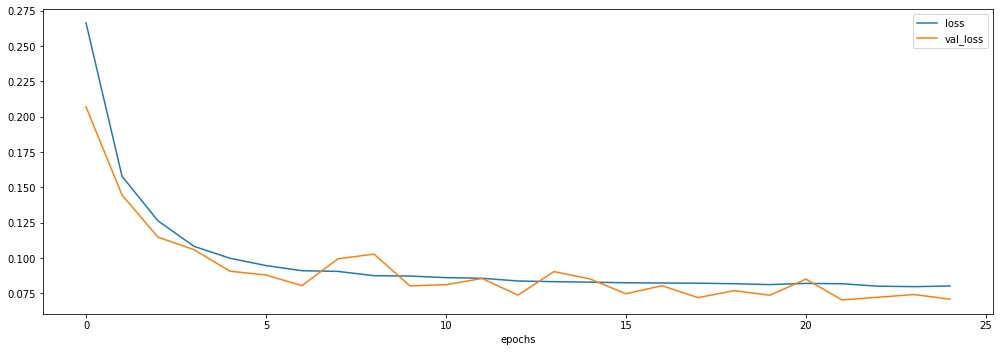

Model loss: 0.0817 (training) 0.0703 (validation)


In [4]:
%time history = util.train_ml_model(nn, tr_s[dt_in], tr_lbl, epochs=25, validation_split=0.2, loss='binary_crossentropy')
nn.save('rul_classifier')
util.plot_training_history(history, figsize=figsize)

## Training the Classifier

**The estimated probabilities follow the correct pattern:**

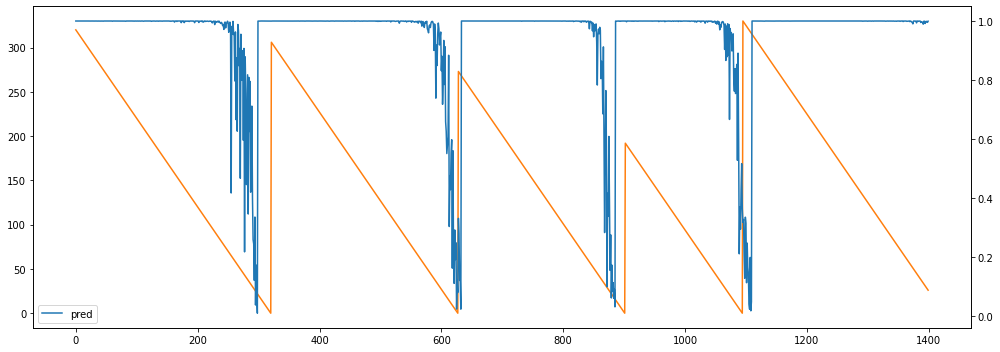

In [5]:
ts_prob = nn.predict(ts_s[dt_in]).ravel()
util.plot_rul(ts_prob[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

## Inspecting the Predictions

**After rounding is applied, this is what we get**

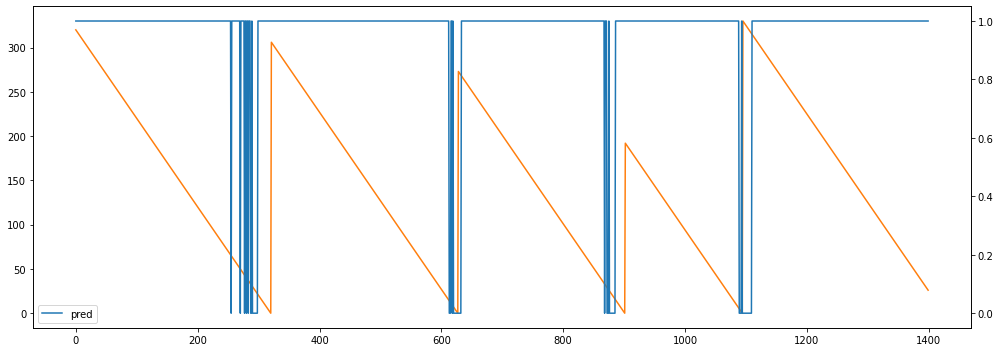

In [6]:
ts_pred = np.round(nn.predict(ts_s[dt_in]).ravel())
util.plot_rul(ts_pred[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

## Evaluation

**We can evaluate the classifier directly**

...Because it defines _the whole policy_

In [7]:
tr_pred = np.round(nn.predict(tr_s[dt_in]).ravel())
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, 0.5, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, 0.5, return_margin=True)
print(f'Cost: {tr_c} (training), {ts_c} (test)')
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Cost: -16760 (training), -6356 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 26.31 (training), 23.05 (test)


It's already working reasonably, but is this the best we can do?

* If we want to know that, we need to search over $\theta$
* ...Except that every evaluation will required up to 20 seconds

# Surrogate Based Black-Box Optimization

Of which Bayesian Optimization is a prime example

## Motivation

**Let's recap our situation.** Our problem is in the form:

$$
\text{argmin}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \omega^*), 0.5) \\
\text{with: } \omega^* = \text{argmin}_\omega \{ L(y, \mathbb{1}_{\hat{y} \geq \theta}) \mid y = f(x, \omega) \}
$$

We need to optimize only over $\theta$, but every evaluation is rather slow

> **How can we efficiently solve it?**

* We need make the best possible use of the available information
* E.g. by _learning as much as possible_ from every evaluated solution

## Surrogate-Based Black Box Optimization

**Classical _Black-box optimization_ approaches**

...Are concerned with problems in the form:

$$
\text{argmin}_x \{ f(x) \mid l \leq x \leq u \}
$$

* Where $x$ is a variable in $\mathbb{R}^n$
* ...And $f$ is a function that we can only evaluate (black-box)
* $l$ and $u$ are bounds for the input variables

**Most black-box optimization solvers rely on a _surrogate model_**

* They approximate $f$ via an internal model $\tilde{f}$
* They choose solutions based on $\tilde{f}$
* They use evaluated solutions to refine $\tilde{f}$

## Surrogate-Based Black Box Optimization

**The basic loop of the algorithm is as follows:**

* $\text{$x^*  = $ the current candidate optimum}$
* $\text{while $i = 1..n_{it}$:}$
  - $x^\prime = \text{argmax}_x \{ g(x) \mid l \leq x \leq u, \tilde{f}(x) < f(x^*) \}$ # Find candidate
  - $\text{if no such $x^\prime$ exists}$ # No more improvements possible
    - $\text{return $x^*$}$
  - $\text{If $f(x^\prime) < f(x^*)$, then $x^* = x^\prime$}$ # Evaluate and possibly update the solution
  - $\text{update $\tilde{f}$}$ # Refine the surrogate model

Where:

* $g$ is called an _acquisition function_ and is related to $\tilde{f}$
* $n_i$ is the maximum number of iterations

## Surrogate-Based Black Box Optimization

**The _surrogate model_ is key to the method operation**

...And it represents a _posterior probability distribution_

* It represents all we know about the true cost function
* We keep it up to date by retraining after each evaluation

For this reason, the approach is also known as _Bayesian Optimization_

**The surrogate exists to support the the $g$ (acquisition) function**

...Which seeks an $x$ with a large-enough _improvement chance_

* This chance is evaluated on the surrogate/posterior $\tilde{f}$
* If $f$ is well behaved, we can give _probabilistic optimality guarantees_

**[Different surrogate-based methods](https://onlinelibrary.wiley.com/doi/abs/10.1111/itor.12292?casa_token=unqdShCTyE8AAAAA:GkXqTqG8vFP3Z30IyKOrl_q42i0mQJctVAes5bWg8an476Sve4ADCUwkvhifUqTaWhJGsbOhDDLu0Q) differ by:**

* The type of acquisition function
* How they balance exploration and exploitation

## A Numeric Example

**Say we want to obtain a minimizer for $f(x) = \frac{1}{1+x} sin(6 \pi x) + x^2$**

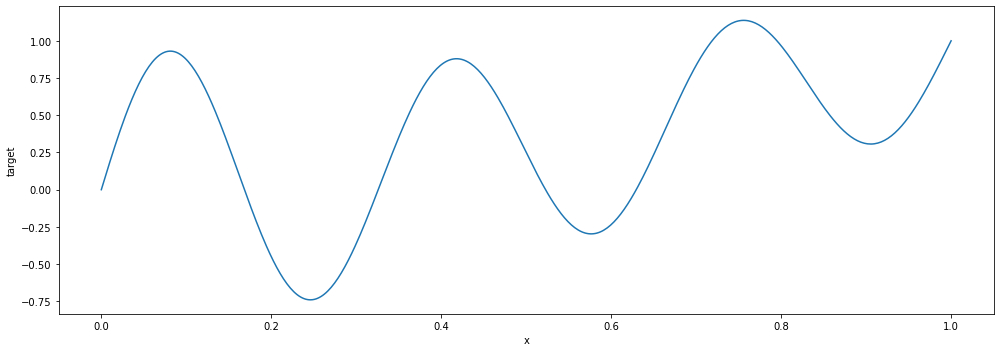

In [8]:
f = lambda x: 1/(1+x) * np.sin(6 * np.pi * x) + x**2
x = np.linspace(0, 1, 500)
target = pd.Series(index=x, data=f(x))
util.plot_series(target, figsize=figsize, ylabel='target', xlabel='x')

This is easy to plot and compute, but challenging due to multiple local optima

## A Numeric Example

**Before updating the surrogate, we would be in this kind of situation:**

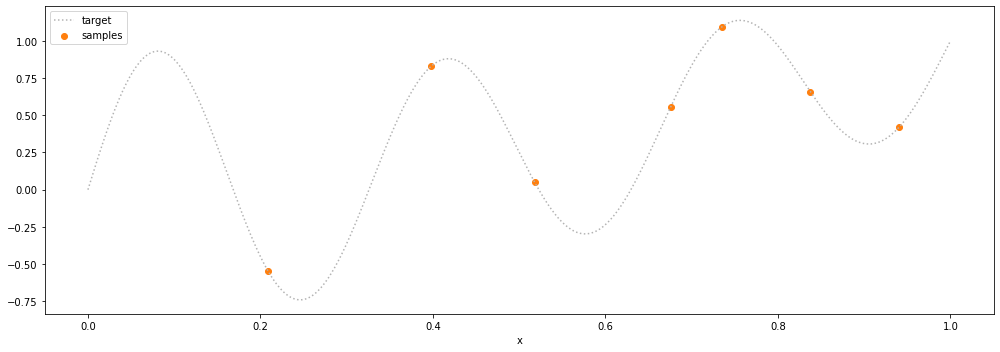

In [9]:
x_sample = np.random.rand(7)
y_sample = pd.Series(index=x_sample, data=f(x_sample))
util.plot_series(samples=y_sample, target=target, figsize=figsize, xlabel='x')

* We would have access to a number of _samples_ (evaluated solutions)
* ...And we wished to obtain an _approximation of the true function_

## Which Surrogate Model?

**Some desiderata for our surrogate model**

...Keeping in mind its goal is to support the acquisition function:

* The surrogate $\tilde{f}$ should output a _probability distribution_
  - ...Or we wouldn't be able to estimate optimality chances
* When we are near a sampled solution, i.e. $x \simeq x^\prime$
  - It should be _very close to its value_, i.e $f(x) \simeq f(x^\prime)$
  - ...Or it would be hard to provide guarantees
* It should change considerably when a single new solution is evaluated
  - ...Or we would need to sample points too close to each other
  - ...Before we finally explore another area

**There aren't many ML method that fit this description**